In [2]:
from imp import reload

import numpy as np
import pandas as pd
import sys,math
import sistercellclass as scc; reload(scc)
import os

import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib inline
plt.rcParams['figure.figsize'] = [16, 9]


/usr/lib64/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
datadir   = '/home/lukas/projects/sistercells/experiments/SISTERS-NONSISTERS/SISTERS/'
datafiles = [os.path.join(datadir,fn) for fn in os.listdir(datadir) if os.path.splitext(fn)[1][1:].upper() == 'XLS']

#datafiles = ['/home/lukas/projects/sistercells/experiments/SISTERS-NONSISTERS/SISTERS/072818POS9_ch2t_sis2.xls']

data      = scc.SisterCellData(infiles = datafiles, debugmode = False)

In [ ]:

for dataID,filename,x in data:
    #print dataID,filename
    cdivA,cdivB = data.CellDivisionTrajectory(dataID)
    #print np.array(cdivA['generationtimeA']),np.array(cdivB['generationtimeB'])
    if dataID == 0:
        gentime = np.concatenate([np.array(cdivA['generationtimeA']),np.array(cdivB['generationtimeB'])])
    else:
        gentime = np.concatenate([gentime,np.array(cdivA['generationtimeA']),np.array(cdivB['generationtimeB'])])
    #print

#np.savetxt('tmp.txt',gentime)
#plt.hist(gentime,range=(0,2),bins=40,log=True)
#print gentime
#print max(gentime)
#gth = dict()
#for x in np.arange(0,2.1,.05):
#    gth['{:.2f}'.format(x)] = 0
#for g in gentime:
#    gth['{:.2f}'.format(g)] += 1

#print gth


In [ ]:
def autocorrelation (x) :
    """
    Compute the autocorrelation of the signal, based on the properties of the
    power spectral density of the signal.
    """
    xp = x-np.mean(x)
    f = np.fft.fft(xp)
    p = np.array([np.real(v)**2+np.imag(v)**2 for v in f])
    pi = np.fft.ifft(p)
    return np.real(pi)[:x.size/2]/np.sum(xp**2)

In [ ]:
acf = dict()
for dataID,filename,x in data:
    a,b = data.CellDivisionTrajectory(dataID)
    for k in [kk for kk in a.keys() if kk[:4]!='time']:
        if not k[:-1] in acf.keys():
            acf[k[:-1]] = list()
        if len(a[k]) > 0:
            tmpacf = autocorrelation(a[k])
            if not np.isnan(tmpacf).any():
                acf[k[:-1]].append(tmpacf)
        if len(b[k[:-1]+'B']) > 0:
            tmpacf = autocorrelation(b[k[:-1] + 'B'])
            if not np.isnan(tmpacf).any():
                acf[k[:-1]].append(tmpacf)

acf_avg = dict()
for k in acf.keys():
    maxl  = np.max([len(a) for a in acf[k]])
    count = np.zeros(maxl)
    acf_avg[k] = np.zeros(maxl)
    for a in acf[k]:
        acf_avg[k][:len(a)] += a
        count[:len(a)] += 1.
    acf_avg[k] /= count
    print k
    #print acf_avg[k]
    plt.plot(np.arange(15),acf_avg[k][:15],label = k)
plt.plot(np.arange(15),np.zeros(15))
plt.legend()
plt.show()

plt.plot(count)

for k in acf_avg.keys():
    np.savetxt('ACF_{}.txt'.format(k),np.array([np.arange(len(acf_avg[k])),acf_avg[k]]).T)

In [ ]:
def gauss(x,mean,sigma2):
    return np.exp(-(x-mean)**2/(2.*sigma2))/np.sqrt(2*math.pi*sigma2)

maxcount = 30

countdiv = np.zeros(maxcount)
for dataID,fn,x in data:
    a,b = data.CellDivisionTrajectory(dataID)
    for t in np.array(a['generationtimeA']/.05,dtype=int):
        if t < maxcount: countdiv[t] += 1
    for t in np.array(b['generationtimeB']/.05,dtype=int):
        if t < maxcount: countdiv[t] += 1

plt.plot(np.arange(maxcount),np.log10(countdiv/np.sum(countdiv)))
plt.plot(np.arange(start=0,stop=maxcount,step=.05),np.log10(gauss(np.arange(start=0,stop=maxcount,step=.05),10.968599386592668,7.605410963650854)))
plt.ylim((-np.log10(np.sum(countdiv))-.5,1))
plt.show()

In [ ]:
m = np.sum(np.arange(maxcount) * countdiv)/np.sum(countdiv)
v = np.sum(np.arange(maxcount)**2 * countdiv)/np.sum(countdiv) - (np.sum(np.arange(maxcount)*countdiv)/np.sum(countdiv))**2
print 'mean: {}, sigma2: {}'.format(m,v)

print 'count all division events: {}'.format(np.sum(countdiv,dtype=int))


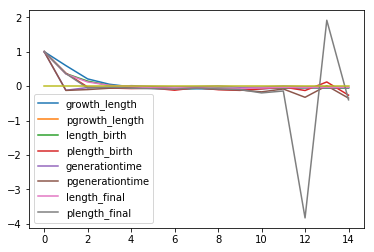

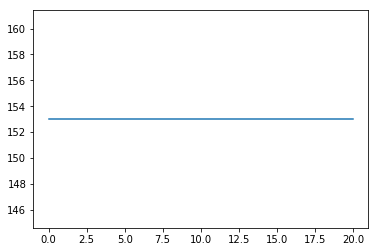

In [37]:
acflen = 20

acf  = dict()
pacf = dict()
for dataID,filename,x in data:
    a,b = data.CellDivisionTrajectory(dataID)
    for k in [kk[:-1] for kk in a.keys() if kk[:-1] != 'time']:
        if not k in acf.keys():
            acf[k]  = list()
            pacf[k] = list()
        la,lb = len(a[k + 'A']),len(b[k + 'B'])
        if len(a[k + 'A']) > acflen and not np.isnan(a[k + 'A']).any():
            acf[k].append(sm.tsa.stattools.acf(a[k + 'A'], nlags = acflen, missing = 'drop'))
            pacf[k].append(sm.tsa.stattools.pacf(a[k + 'A'], nlags = acflen))
        if lb > 20:
            acf[k].append(sm.tsa.stattools.acf(b[k + 'B'], nlags = 20, missing = 'drop'))
            pacf[k].append(sm.tsa.stattools.pacf(b[k + 'B'], nlags = 20))

acf_avg  = dict()
pacf_avg = dict()
for k in acf.keys():
    maxl        = np.max([len(a) for a in acf[k]])
    count       = np.zeros(maxl)
    maxlp       = np.max([len(a) for a in pacf[k]])
    countp      = np.zeros(maxlp)
    acf_avg[k]  = np.zeros(maxl)
    pacf_avg[k] = np.zeros(maxlp)
    for a in acf[k]:
        acf_avg[k][:len(a)] += a
        count[:len(a)] += 1.
    for a in pacf[k]:
        pacf_avg[k][:len(a)] += a
        countp[:len(a)] += 1.
    acf_avg[k] /= count
    pacf_avg[k] /= countp
    plt.plot(np.arange(15),acf_avg[k][:15],label = k)
    plt.plot(np.arange(15),pacf_avg[k][:15],label = 'p' + k)
plt.plot(np.arange(15),np.zeros(15))
plt.legend()
plt.show()

plt.plot(count)

for k in acf_avg.keys():
    np.savetxt('ACF_{}.txt'.format(k),np.array([np.arange(len(acf_avg[k])),acf_avg[k],pacf_avg[k]]).T)

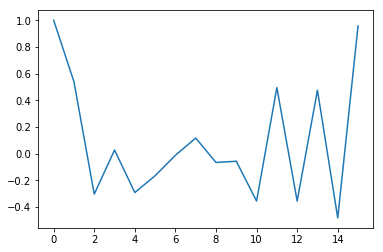

In [34]:
a,b = data.CellDivisionTrajectory(3)
#print a
plt.plot(sm.tsa.stattools.pacf(a['growth_lengthA'],nlags = 15))